<a href="https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Text2Image_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Text2Image v.4.0</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [ru-dalle](https://github.com/sberbank-ai/ru-dalle)

Creator: **[sberbank-ai](https://github.com/sberbank-ai)**

Colab based on neverix's [notebook](https://colab.research.google.com/drive/1F7Irb-00N5NU2lEb3aH5Yzh8RH0c8K1T).

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@MLArt](https://t.me/MLArt),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, поочередно нажимайте на кнопки (куда указывают красные стрелки), дожидаясь завершения выполнения каждого блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries (~ 3-5 min.)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые библиотеки (~ 3-5 мин.)</font></b>

!nvidia-smi -L
!pip install rudalle==0.0.1rc1 > /dev/null

try: 
  !pip3 install googletrans==3.1.0a0
  from googletrans import Translator, constants
  from pprint import pprint
  translator = Translator()
except: pass

from IPython.display import clear_output
clear_output()

from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything

device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
try:
    realesrgan, tokenizer, ruclip, ruclip_processor
except NameError:
    realesrgan = get_realesrgan('x4', device=device)
    tokenizer = get_tokenizer()
    vae = get_vae().to(device)
    ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')
    ruclip = ruclip.to(device)

import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from rudalle import utils


def generate_images(text, tokenizer, dalle, vae, top_k, top_p, images_num, temperature=1.0, bs=8, seed=None,
                    use_cache=True):
    # TODO docstring
    if seed is not None:
        utils.seed_everything(seed)

    vocab_size = dalle.get_param('vocab_size')
    text_seq_length = dalle.get_param('text_seq_length')
    image_seq_length = dalle.get_param('image_seq_length')
    total_seq_length = dalle.get_param('total_seq_length')
    device = dalle.get_param('device')

    text = text.lower().strip()
    input_ids = tokenizer.encode_text(text, text_seq_length=text_seq_length)
    pil_images, scores = [], []
    for chunk in more_itertools.chunked(range(images_num), bs):
        chunk_bs = len(chunk)
        with torch.no_grad():
            attention_mask = torch.tril(torch.ones((chunk_bs, 1, total_seq_length, total_seq_length), device=device))
            out = input_ids.unsqueeze(0).repeat(chunk_bs, 1).to(device)
            # out = input_ids.unsqueeze(0).repeat(chunk_bs, total_seq_length // len(input_ids)).to(device)
            has_cache = False
            sample_scores = []
            for i in tqdm(range(len(input_ids), total_seq_length)):
                logits, has_cache = dalle(out[:, :i], attention_mask,
                                          has_cache=has_cache, use_cache=use_cache, return_loss=False)
                logits = logits[:, -1, vocab_size:]
                logits /= temperature
                filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                sample = torch.multinomial(probs, 1)
                sample_scores.append(probs[torch.arange(probs.size(0)), sample.transpose(0, 1)])
                out = torch.cat((out, sample), dim=-1)
                # out[:, i:i+1] = sample
            codebooks = out[:, -image_seq_length:]
            images = vae.decode(codebooks)
            pil_images += utils.torch_tensors_to_pil_list(images)
            scores += torch.cat(sample_scores).sum(0).detach().cpu().numpy().tolist()
    return pil_images, scores


def show(pil_images, nrow=4):
    imgs = torchvision.utils.make_grid(utils.pil_list_to_torch_tensors(pil_images), nrow=nrow)
    if not isinstance(imgs, list):
        imgs = [imgs.cpu()]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(14, 14))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.show()
    plt.show()

import math
import torch
import torch.nn.functional as F
from rudalle.dalle.utils import divide, split_tensor_along_last_dim


@torch.jit.script
def gelu_impl(x):
    """OpenAI's gelu implementation."""
    return 0.5 * x * (1.0 + torch.tanh(0.7978845608028654 * x * (1.0 + 0.044715 * x * x)))


def gelu(x):
    return gelu_impl(x)


def dalle_layer_forward(self, hidden_states, ltor_mask, has_cache, use_cache):
    # hidden_states: [b, s, h]
    # ltor_mask: [1, 1, s, s]

    # Layer norm at the begining of the transformer layer.
    # output = hidden_states
    # att_has_cache, mlp_has_cache = True, True
    layernorm_output = self.input_layernorm(hidden_states)

    # Self attention.
    attention_output, att_has_cache = self.attention(
        layernorm_output, ltor_mask, has_cache=has_cache, use_cache=use_cache)  # if False else layernorm_output, True

    if self.cogview_sandwich_layernorm:
        attention_output = self.before_first_addition_layernorm(
            attention_output, has_cache=has_cache, use_cache=use_cache)

    # Residual connection.
    layernorm_input = hidden_states + attention_output

    # Layer norm post the self attention.
    layernorm_output = self.post_attention_layernorm(
        layernorm_input, has_cache=has_cache, use_cache=use_cache)

    # MLP.
    # mlp_has_cache = True
    mlp_output, mlp_has_cache = self.mlp(
        layernorm_output, has_cache=has_cache, use_cache=use_cache
        )  # if False else layernorm_output, True

    if self.cogview_sandwich_layernorm:
        mlp_output = self.before_second_addition_layernorm(
            mlp_output, has_cache=has_cache, use_cache=use_cache)

    # Second residual connection.
    output = layernorm_input + mlp_output

    return output, att_has_cache and mlp_has_cache



# About 1.3x speedup. Query/key/value cat is surprisingly fast.
def dalle_sa_forward(self, hidden_states, ltor_mask, has_cache=False, use_cache=False,):
    # hidden_states: [b, s, h]
    # ltor_mask: [1, 1, s, s]
    # Attention heads. [b, s, hp]
    
    def calculate_attention_scores(query_layer, key_layer, ltor_mask):
        key_t = key_layer.transpose(-1, -2)
        if self.cogview_pb_relax:
            attention_scores = torch.matmul(
                query_layer / math.sqrt(self.hidden_size_per_attention_head),
                key_t
            )
        else:
            attention_scores = torch.matmul(query_layer, key_t) / math.sqrt(self.hidden_size_per_attention_head)
        # print(attention_scores.shape, ltor_mask.shape)
        ltor_mask = ltor_mask[:, :, -attention_scores.shape[-2]:]
        # print(attention_scores.shape, ltor_mask.shape)
        attention_scores = torch.mul(attention_scores, ltor_mask) - 10000.0 * (1.0 - ltor_mask)
        if self.cogview_pb_relax:
            # normalize attention scores. Should not affect resulting softmax value
            alpha = 32
            attention_scores_scaled = attention_scores / alpha
            attention_scores_scaled_maxes, _ = attention_scores_scaled.detach().view(
                [attention_scores.size(0), attention_scores.size(1), -1]
            ).max(dim=-1)  # max per head per sample
            attention_scores_scaled_maxes = attention_scores_scaled_maxes.unsqueeze(-1).unsqueeze(-1).expand(
                [-1, -1, attention_scores.size(2), attention_scores.size(3)]
            )  # expand to [b, np, s, s]
            attention_scores = (attention_scores_scaled - attention_scores_scaled_maxes) * alpha
        return attention_scores
    
    t = hidden_states.shape[-2]
    if has_cache and use_cache:
        mixed_x_layer = self.query_key_value(hidden_states[:, self.past_output.shape[-2]:, :])
    else:
        mixed_x_layer = self.query_key_value(hidden_states)

    (mixed_query_layer,
        mixed_key_layer,
        mixed_value_layer) = split_tensor_along_last_dim(mixed_x_layer, 3)

    query_layer = self._transpose_for_scores(mixed_query_layer)
    key_layer = self._transpose_for_scores(mixed_key_layer)
    value_layer = self._transpose_for_scores(mixed_value_layer)

    if use_cache and has_cache:
        value_layer = torch.cat((self.past_value, value_layer), dim=-2)
        key_layer = torch.cat((self.past_key, key_layer), dim=-2)
    attention_scores = calculate_attention_scores(
        query_layer=query_layer, key_layer=key_layer, ltor_mask=ltor_mask
    )

    if use_cache:
        # self.past_query = query_layer
        self.past_key = key_layer
        self.past_value = value_layer
    else:
        has_cache = False

    if use_cache and has_cache:
        attention_scores = attention_scores[..., -1:, :]
        # value_layer = value_layer[..., -1:, :]
    
    # Attention probabilities. [b, np, s, s]
    attention_probs = torch.nn.Softmax(dim=-1)(attention_scores)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_probs = self.attention_dropout(attention_probs)

    # Context layer.
    # [b, np, s, hn]
    context_layer = torch.matmul(attention_probs, value_layer)

    # [b, s, np, hn]
    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()

    new_context_layer_shape = context_layer.size()[:-2] + (self.hidden_size,)
    # [b, s, hp]
    context_layer = context_layer.view(*new_context_layer_shape)

    # Output. [b, s, h]
    output = self.dense(context_layer)

    # print(output.shape)
    if use_cache:
        # Can be simplified, but I didn't for readability's sake
        if has_cache:
            output = torch.cat((self.past_output, output), dim=-2)
            self.past_output = output
        else:
            self.past_output = output
        has_cache = True 
    # print(0, output.shape, t)
    output = self.output_dropout(output)
    # output = hidden_states
    return output, has_cache



def dalle_mlp_forward(self, hidden_states, has_cache=False, use_cache=False):
    if has_cache and use_cache:
        hidden_states = hidden_states[:, self.past_x.shape[1]:]

    # [b, s, 4hp]
    x = self.dense_h_to_4h(hidden_states)
    x = gelu(x)
    # [b, s, h]
    x = self.dense_4h_to_h(x)
    if use_cache:
        # Can be simplified, but I didn't for readability's sake
        if has_cache:
            x = torch.cat((self.past_x, x), dim=-2)
            self.past_x = x
        else:
            self.past_x = x
        has_cache = True
    else:
        has_cache = False
    output = self.dropout(x)
    return output, has_cache


# Speeds up like 6 seconds.
def ln_forward(self, input, has_cache=False, use_cache=False):
    if has_cache and use_cache:
        input = input[:, self.past_output.shape[1]:]
    
    output = F.layer_norm(
        input, self.normalized_shape, self.weight, self.bias, self.eps)
    
    if use_cache:
        # Can be simplified, but I didn't for readability's sake
        if has_cache:
            output = torch.cat((self.past_output, output), dim=1)
            self.past_output = output
        else:
            self.past_output = output
        has_cache = True
    else:
        has_cache = False
    return output  # , has_cache



import inspect
from functools import partial

for layer in dalle.module.transformer.layers:
    layer.forward = partial(dalle_layer_forward, layer)
    layer.mlp.forward = partial(dalle_mlp_forward, layer.mlp)
    layer.attention.past_attentions = None
    layer.attention.past_query = None
    layer.attention.forward = partial(dalle_sa_forward, layer.attention)
    for ln in [layer.input_layernorm,
               layer.before_first_addition_layernorm,
               layer.post_attention_layernorm,
               layer.before_second_addition_layernorm]:
        # print(inspect.getsource(ln.forward))
        ln.forward = partial(ln_forward, ln)

clear_output()
print('Done!')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> ruDALL-E Generation</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Генерация в руДАЛЛ-И</font></b>

from tqdm.auto import tqdm

prompt = 'Wonderful mountain landscape' #@param {type:'string'}
try: text = translator.translate(prompt, dest='ru').text
except: text = prompt

seed = 42 #@param {type:"integer"}

#@markdown ---

#@markdown (ENG) Number of resolutions. Lower this to get faster generations (will produce lower quality pictures)

#@markdown (RUS) Количество разрешений. Уменьшите это значение, чтобы получить более быстрые генерации (будет производить изображения более низкого качества)
num_resolutions = 7 #@param {type:"integer"}

seed_everything(42)

pil_images = []
scores = []

for top_k, top_p, images_num in tqdm([
    # (2048, 0.995, 3),
    # (1536, 0.99, 3),
    # (64, 0.92, 1),
    (1024, 0.98, 3),
    (1024, 0.98, 3),
    (512, 0.97, 3),
    (384, 0.96, 3),
    (256, 0.95, 3),
    (128, 0.95, 3), 
    (64, 0.92, 1)
][::-1][:num_resolutions]):
    _pil_images, _scores = generate_images(text, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    show([pil_image for pil_image, score in sorted(zip(_pil_images, _scores), key=lambda x: -x[1])], 6)
    pil_images += _pil_images
    scores += _scores

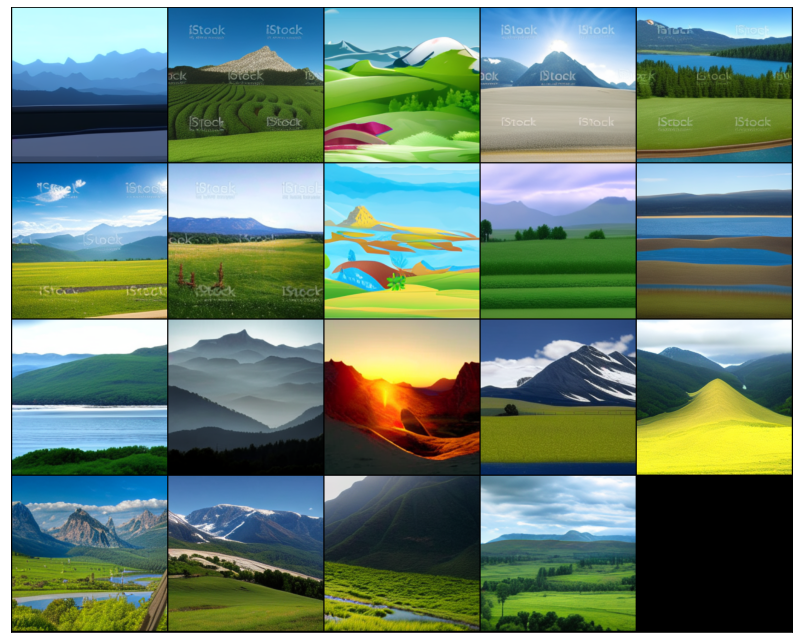

In [3]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Show all results</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Показать все результаты</font></b>

show([pil_image for pil_image, score in sorted(zip(pil_images, scores), key=lambda x: -x[1])], 5)

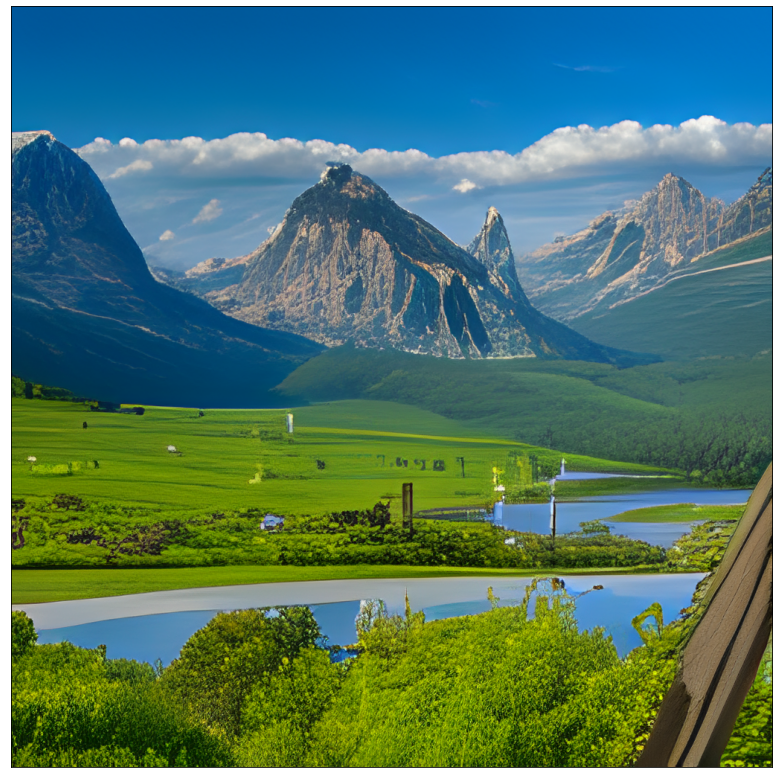

In [4]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Show some of the best results in HD</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Показать несколько лучших результатов в HD</font></b>

top_num = 1 #@param {type:"integer"}

top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device=device, count=top_num)
sr_images = super_resolution(top_images, realesrgan)
show(sr_images, 1)